# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [41]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier as LGBM
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.linalg import qr

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', num_samples=int(1e6)):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.num_samples = num_samples
        self.model = None
        self.pca = None
        self.q = None
        self.b = None
        self.w = None
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_new = X.copy()
        if self.use_PCA:
            self.pca = PCA(n_components = self.new_dim)
            X_new = self.pca.fit_transform(X)
        else:
            self.new_dim = X.shape[1]
        print('PCA done!')
        
        ind1_ = (np.random.choice(len(X_new), self.num_samples))
        ind2_ = (np.random.choice(len(X_new), self.num_samples))
        ind1 = ind1_[ind1_ != ind2_]
        ind2 = ind2_[ind1_ != ind2_]
        self.q = np.median(((X_new[ind1] - X_new[ind2])**2).sum(axis=1))**0.5 #это сигма
        
        self.w = np.random.normal(scale=1 / self.q, size=(self.n_features, self.new_dim)) #это матрица весов w
        self.b = np.random.uniform(low=-math.pi, high=math.pi, size=self.n_features) #это ветор весов b
        
        phi = np.cos(self.w @ X_new.T + np.repeat(self.b.reshape(-1, 1), len(X_new), axis=1)).T #это итоговые новые признаки
        
        print('Start fitting!')
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC()
        self.model.fit(phi, y)
        #raise NotImplementedError
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_new = X.copy()
        if self.use_PCA:
            X_new = self.pca.transform(X)
        phi = np.cos(self.w @ X_new.T + np.repeat(self.b.reshape(-1, 1), len(X_new), axis=1)).T
        if self.classifier == 'logreg':
            return self.model.predict_proba(phi)
        elif self.classifier == 'svm':
            return softmax(self.model.decision_function(phi))
        #raise NotImplementedError
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        X_new = X.copy()
        if self.use_PCA:
            X_new = self.pca.transform(X)
        phi = np.cos(self.w @ X_new.T + np.repeat(self.b.reshape(-1, 1), len(X_new), axis=1)).T
        return self.model.predict(phi)
        #raise NotImplementedError

In [16]:
clf = RFFPipeline()
clf.fit(x_train, y_train)

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RFFPipeline()

In [18]:
accuracy_score(y_test, clf.predict(x_test))

0.8576

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

Тут сдохнуть можно ждать иногда, поэтому на всякий случай будем брать 20% обуч выборки

In [10]:
ind = np.random.choice(len(x_train), int(len(x_train) * 0.2), replace=False)

In [3]:
svm = SVC()
svm.fit(x_train[ind], y_train[ind])

SVC()

In [8]:
kernel_svm = RFFPipeline(classifier='svm')
kernel_svm.fit(x_train[ind], y_train[ind])

PCA done!
Start fitting!


RFFPipeline(classifier='svm')

In [4]:
accuracy_score(y_test, svm.predict(x_test))

0.8584

In [9]:
accuracy_score(y_test, kernel_svm.predict(x_test))

0.8414

В общем, все 3 дали примерно одинаковые резы. 
Но так-то svm на начальных признаках оказался лучше почему-то, чем на подготовленных (навреное при PCA теряем слишком много инфы). RFF на логреге дал результат чуть получше, но там и обучающая выборка в 5 раз больше была. Так-то, я думаю, примерно тот же эффект был бы.
Дальше про бустинг

In [12]:
pca = PCA(n_components = 50)
x_train_new = pca.fit_transform(x_train)

In [45]:
bst = catboost.CatBoostClassifier()
grid_search_result = bst.grid_search({'learning_rate':np.logspace(-2, 2, 5), 'iterations':np.arange(50, 301, 50)},
                                     X=x_train_new[ind], y=y_train[ind])


bestTest = 1.47801521
bestIteration = 49

0:	loss: 1.4780152	best: 1.4780152 (0)	total: 7.3s	remaining: 3m 31s

bestTest = 0.6008116335
bestIteration = 49

1:	loss: 0.6008116	best: 0.6008116 (1)	total: 14.5s	remaining: 3m 23s

bestTest = 0.6272964316
bestIteration = 43

2:	loss: 0.6272964	best: 0.6008116 (1)	total: 20.9s	remaining: 3m 8s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 9.609378409
bestIteration = 0

3:	loss: 9.6093784	best: 0.6008116 (1)	total: 27.1s	remaining: 2m 56s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 96.03227356
bestIteration = 0

4:	loss: 96.0322736	best: 0.6008116 (1)	total: 33.5s	remaining: 2m 47s

bestTest = 1.155178172
bestIteration = 99

5:	loss: 1.1551782	best: 0.6008116 (1)	total: 46s	remaining: 3m 4s

bestTest = 0.4872124526
bestIteration = 99

6:	loss: 0.4872125	best: 0.4872125 (6)	total: 58.8s	remaining: 3m 13s

bestTest = 0.601209537
bestIteration = 86

7:	loss: 0.6012095	best: 0.4872125 (6)	total: 1m 10s	remaining: 3m 14s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 9.609378409
bestIteration = 0

8:	loss: 9.6093784	best: 0.4872125 (6)	total: 1m 23s	remaining: 3m 13s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 96.03227356
bestIteration = 0

9:	loss: 96.0322736	best: 0.4872125 (6)	total: 1m 35s	remaining: 3m 10s

bestTest = 0.9708719727
bestIteration = 149

10:	loss: 0.9708720	best: 0.4872125 (6)	total: 1m 54s	remaining: 3m 17s

bestTest = 0.446492127
bestIteration = 149

11:	loss: 0.4464921	best: 0.4464921 (11)	total: 2m 13s	remaining: 3m 19s

bestTest = 0.6009202077
bestIteration = 125

12:	loss: 0.6009202	best: 0.4464921 (11)	total: 2m 31s	remaining: 3m 18s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 9.609378409
bestIteration = 0

13:	loss: 9.6093784	best: 0.4464921 (11)	total: 2m 49s	remaining: 3m 14s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 96.03227356
bestIteration = 0

14:	loss: 96.0322736	best: 0.4464921 (11)	total: 3m 8s	remaining: 3m 8s

bestTest = 0.858749035
bestIteration = 199

15:	loss: 0.8587490	best: 0.4464921 (11)	total: 3m 34s	remaining: 3m 7s

bestTest = 0.4261547293
bestIteration = 199

16:	loss: 0.4261547	best: 0.4261547 (16)	total: 3m 59s	remaining: 3m 2s

bestTest = 0.6009202077
bestIteration = 125

17:	loss: 0.6009202	best: 0.4261547 (16)	total: 4m 22s	remaining: 2m 55s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 9.609378409
bestIteration = 0

18:	loss: 9.6093784	best: 0.4261547 (16)	total: 4m 47s	remaining: 2m 46s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 96.03227356
bestIteration = 0

19:	loss: 96.0322736	best: 0.4261547 (16)	total: 5m 12s	remaining: 2m 36s

bestTest = 0.779607983
bestIteration = 249

20:	loss: 0.7796080	best: 0.4261547 (16)	total: 5m 43s	remaining: 2m 27s

bestTest = 0.4117861895
bestIteration = 249

21:	loss: 0.4117862	best: 0.4117862 (21)	total: 6m 14s	remaining: 2m 16s

bestTest = 0.6009202077
bestIteration = 125

22:	loss: 0.6009202	best: 0.4117862 (21)	total: 6m 44s	remaining: 2m 3s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 9.609378409
bestIteration = 0

23:	loss: 9.6093784	best: 0.4117862 (21)	total: 7m 16s	remaining: 1m 49s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 96.03227356
bestIteration = 0

24:	loss: 96.0322736	best: 0.4117862 (21)	total: 7m 46s	remaining: 1m 33s

bestTest = 0.7230278745
bestIteration = 299

25:	loss: 0.7230279	best: 0.4117862 (21)	total: 8m 24s	remaining: 1m 17s

bestTest = 0.402563924
bestIteration = 298

26:	loss: 0.4025639	best: 0.4025639 (26)	total: 9m	remaining: 1m

bestTest = 0.6009202077
bestIteration = 125

27:	loss: 0.6009202	best: 0.4025639 (26)	total: 9m 36s	remaining: 41.2s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 9.609378409
bestIteration = 0

28:	loss: 9.6093784	best: 0.4025639 (26)	total: 10m 12s	remaining: 21.1s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 96.03227356
bestIteration = 0

29:	loss: 96.0322736	best: 0.4025639 (26)	total: 10m 49s	remaining: 0us
Estimating final quality...


In [47]:
search_params = grid_search_result['params']
search_params

{'iterations': 300, 'learning_rate': 0.1}

In [52]:
bst = catboost.CatBoostClassifier(iterations=search_params['iterations'],
                                  learning_rate=search_params['learning_rate'])
bst.fit(x_train, y_train)

0:	learn: 1.9113553	total: 4.35s	remaining: 21m 41s
1:	learn: 1.6853523	total: 8.75s	remaining: 21m 44s
2:	learn: 1.5218125	total: 12.5s	remaining: 20m 34s
3:	learn: 1.3927017	total: 16.1s	remaining: 19m 53s
4:	learn: 1.2920560	total: 19.7s	remaining: 19m 24s
5:	learn: 1.2095348	total: 23.4s	remaining: 19m 6s
6:	learn: 1.1383237	total: 27.2s	remaining: 18m 58s
7:	learn: 1.0750241	total: 30.9s	remaining: 18m 49s
8:	learn: 1.0238835	total: 34.7s	remaining: 18m 40s
9:	learn: 0.9718917	total: 38.4s	remaining: 18m 34s
10:	learn: 0.9304233	total: 42.3s	remaining: 18m 30s
11:	learn: 0.8940073	total: 46s	remaining: 18m 24s
12:	learn: 0.8593684	total: 49.7s	remaining: 18m 18s
13:	learn: 0.8288367	total: 53.4s	remaining: 18m 11s
14:	learn: 0.7991806	total: 57.2s	remaining: 18m 5s
15:	learn: 0.7748049	total: 1m	remaining: 18m 1s
16:	learn: 0.7522235	total: 1m 4s	remaining: 17m 58s
17:	learn: 0.7311923	total: 1m 8s	remaining: 17m 53s
18:	learn: 0.7141401	total: 1m 12s	remaining: 17m 48s
19:	learn:

154:	learn: 0.3322996	total: 8m 47s	remaining: 8m 13s
155:	learn: 0.3318208	total: 8m 50s	remaining: 8m 9s
156:	learn: 0.3308251	total: 8m 53s	remaining: 8m 6s
157:	learn: 0.3298949	total: 8m 56s	remaining: 8m 2s
158:	learn: 0.3288581	total: 9m	remaining: 7m 59s
159:	learn: 0.3284808	total: 9m 3s	remaining: 7m 55s
160:	learn: 0.3276723	total: 9m 6s	remaining: 7m 52s
161:	learn: 0.3270298	total: 9m 10s	remaining: 7m 48s
162:	learn: 0.3265172	total: 9m 13s	remaining: 7m 45s
163:	learn: 0.3260924	total: 9m 16s	remaining: 7m 41s
164:	learn: 0.3258680	total: 9m 19s	remaining: 7m 37s
165:	learn: 0.3254831	total: 9m 22s	remaining: 7m 34s
166:	learn: 0.3250574	total: 9m 25s	remaining: 7m 30s
167:	learn: 0.3244064	total: 9m 28s	remaining: 7m 27s
168:	learn: 0.3235291	total: 9m 32s	remaining: 7m 23s
169:	learn: 0.3231744	total: 9m 35s	remaining: 7m 19s
170:	learn: 0.3225392	total: 9m 38s	remaining: 7m 16s
171:	learn: 0.3221578	total: 9m 41s	remaining: 7m 12s
172:	learn: 0.3212146	total: 9m 45s	r

In [53]:
accuracy_score(y_test, bst.predict(x_test))

0.8728

300 деревьев, 16 минут... Стоило ли оно 2% аккураси? Вопрос, достойный размышления...(нет)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?

Это точно помогает, без него вообще не рабит (аккураси падает с 85% до 10%)

2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?

Оно растет до какого-то момента, потом выходит на плато. Ну и начинает немного шуметь.

3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Получилось, что важно. Качество дают схожее (но в нашем случае логрег получше почему-то справился), а вот время обучения отличается кардинально (свм сас). Время предсказаний (бдмсссс) еще кардинальней)

In [62]:
#RFF на logreg
clf = RFFPipeline()
start_time = time.time()
clf.fit(x_train[ind], y_train[ind])
print(f'fit time: {time.time() - start_time} sec')
start_time = time.time()
print(f'accuracy: {accuracy_score(y_test, clf.predict(x_test))}')
print(f'fit time: {time.time() - start_time} sec')

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit time: 6.818558216094971 sec
accuracy: 0.8514
fit time: 0.40403008460998535 sec


In [63]:
#RFF на logreg без понижения размерности
clf = RFFPipeline(use_PCA=False)
start_time = time.time()
clf.fit(x_train[ind], y_train[ind])
print(f'fit time: {time.time() - start_time} sec')
start_time = time.time()
print(f'accuracy: {accuracy_score(y_test, clf.predict(x_test))}')
print(f'fit time: {time.time() - start_time} sec')

PCA done!
Start fitting!
fit time: 4.796139717102051 sec
accuracy: 0.1034
fit time: 0.6040472984313965 sec


In [65]:
#RFF на SVM
clf = RFFPipeline(classifier='svm')
start_time = time.time()
clf.fit(x_train[ind], y_train[ind])
print(f'fit time: {time.time() - start_time} sec')
start_time = time.time()
print(f'accuracy: {accuracy_score(y_test, clf.predict(x_test))}')
print(f'fit time: {time.time() - start_time} sec')

PCA done!
Start fitting!
fit time: 38.20696711540222 sec
accuracy: 0.837
fit time: 52.111276626586914 sec


In [69]:
accuracy = []
scale = np.arange(500, 2000, 100)
for n in scale:
    clf = RFFPipeline(n_features=n)
    clf.fit(x_train[ind], y_train[ind])
    accuracy.append(accuracy_score(y_test, clf.predict(x_test)))

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


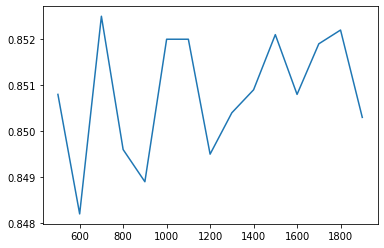

In [70]:
plt.plot(scale, accuracy)

На картинке изображено плато. 

(после этих слов в горный поход со мной никто не пошел:( )

Но вообще видно, что отличие в 3 знаке только, поэтому плато настало даже на n_features=500. 

Вот запуск для небольших n_features, видно, что в начале рост приличный, но явно замедляющийся.

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


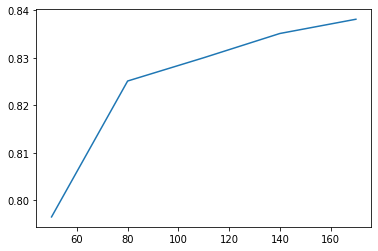

In [6]:
accuracy = []
scale = np.arange(50, 200, 30)
for n in scale:
    clf = RFFPipeline(n_features=n)
    clf.fit(x_train[ind], y_train[ind])
    accuracy.append(accuracy_score(y_test, clf.predict(x_test)))
plt.plot(scale, accuracy)

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', num_samples=int(1e6)):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.num_samples = num_samples
        self.model = None
        self.pca = None
        self.q = None
        self.b = None
        self.w = None
        
    def fit(self, X, y):
        X_new = X.copy()
        if self.use_PCA:
            self.pca = PCA(n_components = self.new_dim)
            X_new = self.pca.fit_transform(X)
        else:
            self.new_dim = X.shape[1]
        print('PCA done!')
        
        ind1_ = (np.random.choice(len(X_new), self.num_samples))
        ind2_ = (np.random.choice(len(X_new), self.num_samples))
        ind1 = ind1_[ind1_ != ind2_]
        ind2 = ind2_[ind1_ != ind2_]
        self.q = np.median(((X_new[ind1] - X_new[ind2])**2).sum(axis=1))**0.5 #это сигма
        
        m = math.ceil(self.n_features / self.new_dim)
        ans = []
        for i in range(m):
            S = np.diag(np.random.chisquare(df=self.new_dim, size=self.new_dim))
            Q = qr(np.random.randn(self.new_dim, self.new_dim))[0]
            ans.append(S @ Q)
        self.w = np.concatenate(ans)[:self.n_features] / self.q
        #self.b = np.random.uniform(low=-math.pi, high=math.pi, size=self.n_features) #это ветор весов b
        
        #phi = np.cos(self.w @ X_new.T + np.repeat(self.b.reshape(-1, 1), len(X_new), axis=1)).T #это итоговые новые признаки
        phi = np.concatenate([np.cos(self.w @ X_new.T), np.sin(self.w @ X_new.T)]).T
        
        print('Start fitting!')
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC()
        self.model.fit(phi, y)
        return self

    def predict_proba(self, X):
        X_new = X.copy()
        if self.use_PCA:
            X_new = self.pca.transform(X)
        #phi = np.cos(self.w @ X_new.T + np.repeat(self.b.reshape(-1, 1), len(X_new), axis=1)).T
        phi = np.concatenate([np.cos(self.w @ X_new.T), np.sin(self.w @ X_new.T)]).T
        if self.classifier == 'logreg':
            return self.model.predict_proba(phi)
        elif self.classifier == 'svm':
            return softmax(self.model.decision_function(phi))
        
    def predict(self, X):
        X_new = X.copy()
        if self.use_PCA:
            X_new = self.pca.transform(X)
        #phi = np.cos(self.w @ X_new.T + np.repeat(self.b.reshape(-1, 1), len(X_new), axis=1)).T
        phi = np.concatenate([np.cos(self.w @ X_new.T), np.sin(self.w @ X_new.T)]).T
        return self.model.predict(phi)

In [6]:
clf = ORFPipeline()
clf.fit(x_train, y_train)
accuracy_score(y_test, clf.predict(x_test))

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7157

Кстати, если реализовывать без вектором сдвигов (которые b), а с синусами, то это дает улучшение аккураси на 0.03.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

Сначала я напишу функцию по преобразованию признаков. Там будут разные режимы, вот надо на них смотреть. Дальше сам класс классификатора идентичен тому, что был выше.

In [86]:
# Это будет функция преобразования исходных признаков в новые
# mode - то, как преобразовывать (0 - RFF)
def new_features(X, n_features, d, q, mode, params=None):
    if mode == 0:
        b = w = 0
        if params is None:
            b = np.random.uniform(low=-math.pi, high=math.pi, size=n_features)
            w = np.random.normal(scale=1 / q, size=(n_features, d))
        else:
            w, b = params[0], params[1]
        return np.cos(w @ X.T + np.repeat(b.reshape(-1, 1), len(X), axis=1)).T, (w, b)
    elif mode == 1:
        w = 0
        if params is None:
            w = np.random.normal(scale=1 / q, size=(n_features, d))
        else:
            w = params
        return np.sign(w @ X.T).T, w
    elif mode == 2:
        w = b = 0
        if params is None:
            w = np.random.normal(scale=1 / q, size=(n_features, d))
            b = np.random.normal(size = n_features)
        else:
            w, b = params[0], params[1]
        return np.sign(w @ X.T + np.repeat(b.reshape(-1, 1), len(X), axis=1)).T, (w, b)
    elif mode == 3: #лог-мономы
        Deg = 0
        sgn = 0
        if params is None:
            Deg = np.random.randint(low=0, high=10, size=(d, n_features))
            sgn = np.random.choice([-1, 1], size=n_features)
        else:
            Deg, sgn = params[0], params[1]
        return (np.log(np.abs(X)) @ Deg) * np.repeat(sgn.reshape(1, -1), len(X), axis=0), (Deg, sgn)
    elif mode == 4: #лог-мономы со сдвигами
        b = 0
        Deg = 0
        sgn = 0
        if params is None:
            b = np.random.normal(scale = q, size = (1, d))
            Deg = np.random.randint(low=0, high=3, size=(d, n_features))
            sgn = np.random.choice([-1, 1], size=(1, n_features))
        else:
            b, Deg, sgn = params[0], params[1], params[2]
        return (np.log(np.abs(X + np.repeat(b, len(X), axis=0))) @ Deg) * np.repeat(sgn, len(X), axis=0), (b, Deg, sgn)

In [58]:
# для начала напишем класс
from sklearn.base import BaseEstimator, TransformerMixin


class MYPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', num_samples=int(1e6), mode=0):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.num_samples = num_samples
        self.model = None
        self.pca = None
        self.q = None
        self.params = None
        self.mode = mode
        
    def fit(self, X, y):
        X_new = X.copy()
        if self.use_PCA:
            self.pca = PCA(n_components = self.new_dim)
            X_new = self.pca.fit_transform(X)
        else:
            self.new_dim = X.shape[1]
        print('PCA done!')
        
        ind1_ = (np.random.choice(len(X_new), self.num_samples))
        ind2_ = (np.random.choice(len(X_new), self.num_samples))
        ind1 = ind1_[ind1_ != ind2_]
        ind2 = ind2_[ind1_ != ind2_]
        self.q = np.median(((X_new[ind1] - X_new[ind2])**2).sum(axis=1))**0.5 #это сигма
        
        phi, self.params = new_features(X_new, self.n_features, self.new_dim, self.q, mode=self.mode)
        
        print('Start fitting!')
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC()
        elif self.classifier == 'boosting':
            self.model = CatBoostClassifier(iterations=30)
        self.model.fit(phi, y)
        return self

    def predict_proba(self, X):
        X_new = X.copy()
        if self.use_PCA:
            X_new = self.pca.transform(X)
        phi, _ = new_features(X_new, self.n_features, self.new_dim, self.q, mode=self.mode, params=self.params)
        if self.classifier == 'logreg':
            return self.model.predict_proba(phi)
        elif self.classifier == 'svm':
            return softmax(self.model.decision_function(phi))
        return 0
        
    def predict(self, X):
        X_new = X.copy()
        if self.use_PCA:
            X_new = self.pca.transform(X)
        phi, _ = new_features(X_new, self.n_features, self.new_dim, self.q, mode=self.mode, params=self.params)
        return self.model.predict(phi)

In [61]:
#пробуем на дефолтных настройках
clf = MYPipeline()
clf.fit(x_train[ind], y_train[ind])
accuracy_score(y_test, clf.predict(x_test))

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8532

In [51]:
# пробуем бустинг на случайных признаках
clf = MYPipeline(classifier='boosting')
clf.fit(x_train[ind], y_train[ind])

PCA done!
Start fitting!
Learning rate set to 0.5
0:	learn: 1.3332630	total: 3.01s	remaining: 1m 27s
1:	learn: 1.0689765	total: 6.06s	remaining: 1m 24s
2:	learn: 0.9183392	total: 9.04s	remaining: 1m 21s
3:	learn: 0.8242446	total: 11.8s	remaining: 1m 16s
4:	learn: 0.7620043	total: 14.5s	remaining: 1m 12s
5:	learn: 0.7071861	total: 17s	remaining: 1m 7s
6:	learn: 0.6725813	total: 19.5s	remaining: 1m 4s
7:	learn: 0.6382281	total: 22.1s	remaining: 1m
8:	learn: 0.6138504	total: 24.7s	remaining: 57.5s
9:	learn: 0.5961494	total: 27.1s	remaining: 54.1s
10:	learn: 0.5746249	total: 29.5s	remaining: 51s
11:	learn: 0.5580064	total: 32s	remaining: 48.1s
12:	learn: 0.5433017	total: 34.6s	remaining: 45.3s
13:	learn: 0.5284160	total: 37.2s	remaining: 42.5s
14:	learn: 0.5127997	total: 39.8s	remaining: 39.8s
15:	learn: 0.5002306	total: 42.2s	remaining: 36.9s
16:	learn: 0.4869868	total: 44.7s	remaining: 34.2s
17:	learn: 0.4816735	total: 47.3s	remaining: 31.5s
18:	learn: 0.4745970	total: 49.7s	remaining: 2

MYPipeline(classifier='boosting')

In [52]:
accuracy_score(y_test, clf.predict(x_test))
# бустинг на RFF - хуже (дольше и качество меньше)

0.7972

In [60]:
# пробуем знак вместо косинуса и без сдвига
clf = MYPipeline(mode=1)
clf.fit(x_train[ind], y_train[ind])
accuracy_score(y_test, clf.predict(x_test))
# резы похуже, чем по умолчанию, но сравнимо с бустингом

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7945

In [66]:
# а если к знакам добавить нормальные сдвиги?
clf = MYPipeline(mode=2)
clf.fit(x_train[ind], y_train[ind])
accuracy_score(y_test, clf.predict(x_test))
# ну на 0.02 аккураси подняли, сойдет

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8163

In [87]:
# логарифмированные мономы
clf = MYPipeline(n_features=2000, new_dim=100, mode=3)
clf.fit(x_train[ind], y_train[ind])
accuracy_score(y_test, clf.predict(x_test))
# чет не пошло

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6111

In [88]:
# логарифмированные мономы со сдвигами
clf = MYPipeline(n_features=2000, new_dim=100, mode=4)
clf.fit(x_train[ind], y_train[ind])
accuracy_score(y_test, clf.predict(x_test))
# тоже отстойно, но лучше

PCA done!
Start fitting!


c:\users\danill\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.686